# Problem 1

### Getting familiar with loading, visualizing and operating on multivariate data

A Hess diagram is a 2D plot coded by a third quantity.

Here's an example from the [astroML documentation](https://www.astroml.org/examples/datasets/plot_SDSS_SSPP.html) showing the temperature and surface gravity (how strongly the star would pull on you if you could stand on it's surface, including the effect of rotation), color coded on the left by density, and on the right by metallicity (measured here as the ratio of iron to hydrogen) with density contours.


<img src="https://www.astroml.org/_images/plot_SDSS_SSPP_1.png">

From http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/, download eight HLC\*fits.gz files (and recall how you can use `astropy.io.fits` to load these)

The HLC files are each different bands on the sky.

For each HLC file, separate stars and galaxies by using the `MEAN_OBJECT_TYPE` column and making a cut with value > 5 to find stars.

For each HLC file, and separately for stars and galaxies make a 3-panel plot.

In the left plot show `r` vs `g-i` color coded by density (recall we did this with `seaborn`'s `jointplot`, but you can use whatever).

Estimate a bivariate distribution for `density(r, g-i)` this sample (recall we did with `seaborn`'s `jointplot` use `kde`, but you can use whatever).

In the middle and right panel, again plot `r` vs `g-i`, but now color-coded by proper motion in RA, and Dec. Overlay the density contors.

Comment on the structure in stars vs galaxies, and the evolution with position on the sky in each HLC.


In [1]:
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_22_to_23.fits.gz
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_23_to_24.fits.gz
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_00_to_01.fits.gz
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_01_to_02.fits.gz
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_02_to_03.fits.gz
#!wget http://das.sdss.org/va/stripe_82_variability/SDSS_82_public/HLC.RA_03_to_04.fits.gz

In [2]:
#!gunzip *.fits.gz

In [2]:
fit1 = fits.open("HLC.RA_22_to_23.fits")
#fit1[1].header['TTYPE33']
#fit1[1].columns
#fit1[1].data['MEAN_OBJECT_TYPE']

In [55]:
mydata = fit1[1].data
star_index = mydata['MEAN_OBJECT_TYPE']> 5.
galx_index = mydata['MEAN_OBJECT_TYPE']< 5.
magnitude_name = "MEAN_PSFMAG"

#ugriz
star_mag = mydata[magnitude_name][star_index,:]
#galx_mag = mydata[magnitude_name][galx_index,:]

rBand = star_mag[:,2] # x axis
g_iBand = star_mag[:,1] - star_mag[:,3] #y axis
starRA = mydata['RA_PM'][star_index]
starDec = mydata['DEC_PM'][star_index]


AttributeError: 'JointGrid' object has no attribute 'set_title'

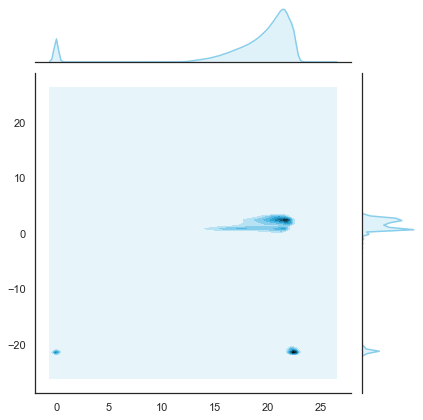

In [41]:
sns.set(style="white", color_codes=True)
sns.jointplot(x=rBand,y=g_iBand, kind='kde', color="skyblue")

(0.3026535034179688, 3.0603038406372063)

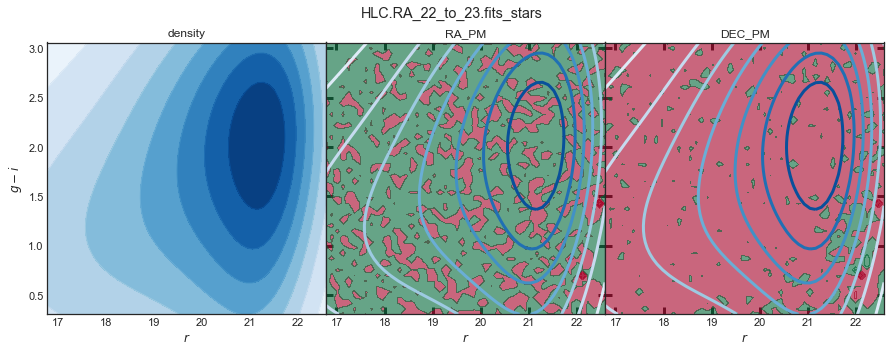

In [56]:
density = np.vstack([rBand,g_iBand])
density_kde = gaussian_kde(density)

xmin = np.quantile(rBand,0.15)
xmax = np.quantile(rBand,0.98)
ymin = np.quantile(g_iBand,0.15)
ymax = np.quantile(g_iBand,0.98)

#xgrid = np.linspace(np.amin(rBand),np.amax(rBand),50)
#ygrid = np.linspace(np.amin(g_iBand),np.amax(g_iBand),50)

xgrid = np.linspace(xmin,xmax,50)
ygrid = np.linspace(ymin,ymax,50)

Xgrid,Ygrid = np.meshgrid(xgrid,ygrid)
pos = np.vstack([Xgrid,Ygrid])
Z = density_kde.evaluate(np.vstack([Xgrid.ravel(),Ygrid.ravel()]) )

starRA_g = griddata(density.T, starRA, (Xgrid,Ygrid),method='linear') #cubic
starDec_g = griddata(density.T,starDec,(Xgrid,Ygrid),method='linear') #cubic


plt.figure(figsize=(15,5))
plt.suptitle('HLC.RA_22_to_23.fits_stars')
gs1 = gridspec.GridSpec(1,3)

gs1.update(wspace = 0.00,hspace=0.01)
ax0 = plt.subplot(gs1[:,0])
ax0.contourf(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues')
ax0.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=1.0)
ax0.tick_params(width=3, length=7, axis='x',direction='in', top=True )
ax0.tick_params(width=3, length=7, axis='y',direction='in', right=True, left=True )
ax0.set(xlabel=r"$r$",ylabel=r"$g-i$")
ax0.set_title("density")
ax0.set_xlim([xmin,xmax])
ax0.set_ylim([ymin,ymax])

ax1 = plt.subplot(gs1[:,1])
#ax1.scatter(rBand,g_iBand,c=starRA, s= 2, alpha=0.1,vmin = np.quantile(starRA,0.1), vmax= np.quantile(starRA,0.9),cmap="copper" )
ax1.contourf(Xgrid,Ygrid, starRA_g,vmin = np.quantile(starRA,0.01), vmax= np.quantile(starRA,0.99), cmap="RdYlGn", alpha=0.6)
ax1.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=3)
ax1.tick_params(width=3, length=7,axis='x',direction='in', top=True, bottom=True )
ax1.tick_params(width=3, length=7,axis='y',direction='in', right=True, left=True )
ax1.set_yticklabels([])
ax1.set(xlabel=r"$r$")
ax1.set_title("RA_PM")
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])

ax2 = plt.subplot(gs1[:,2])
ax2.contourf(Xgrid,Ygrid, starDec_g, vmin = np.quantile(starDec,0.01), vmax= np.quantile(starDec,0.99), cmap="RdYlGn",alpha=0.6)
ax2.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=3)
#ax2.scatter(rBand,g_iBand,c=starDec, s= 1, alpha=0.1,vmin = np.quantile(starDec,0.1), vmax= np.quantile(starDec,0.9)  )
ax2.tick_params(width=3, length=7, axis='x',direction='in', top=True, bottom=True )
ax2.tick_params(width=3, length=7, axis='y',direction='in', right=True, left=True )
ax2.set_yticklabels([])
ax2.set(xlabel=r"$r$")
ax2.set_title("DEC_PM")
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])

In [4]:
import astropy as ap
import astropy.io.fits as fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata

def SG_plot(mydata,index, filename, SG, magnitude_name="MEAN_PSFMAG", RA_name='RA_PM', Dec_name= "DEC_PM"):
    #ugriz
    mag = mydata[magnitude_name][index,:]
    rBand = mag[:,2] # x axis
    g_iBand = mag[:,1] - mag[:,3] #y axis
    RA = mydata[RA_name][index]
    Dec = mydata[Dec_name][index]
    
    #sns.jointplot(x=rBand,y=g_iBand, kind='kde', color="skyblue")
    density = np.vstack([rBand,g_iBand])
    density_kde = gaussian_kde(density)

    xmin = np.quantile(rBand,0.2)
    xmax = np.quantile(rBand,0.98)
    ymin = -0.1#np.quantile(g_iBand,0.2)
    ymax = np.quantile(g_iBand,0.98)

    xgrid = np.linspace(xmin,xmax,50)
    ygrid = np.linspace(ymin,ymax,50)

    Xgrid,Ygrid = np.meshgrid(xgrid,ygrid)
    pos = np.vstack([Xgrid,Ygrid])
    Z = density_kde.evaluate(np.vstack([Xgrid.ravel(),Ygrid.ravel()]) )

    RA_g = griddata(density.T, RA, (Xgrid,Ygrid),method='cubic') #cubic spline
    Dec_g = griddata(density.T,Dec,(Xgrid,Ygrid),method='cubic')
    
    plt.figure(figsize=(15,5))
    plt.suptitle(filename+"_" + SG)
    gs1 = gridspec.GridSpec(1,3)

    gs1.update(wspace = 0.00,hspace=0.01)
    ax0 = plt.subplot(gs1[:,0])
    ax0.contourf(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues')
    ax0.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=1.0)
    ax0.tick_params(width=3, length=7, axis='x',direction='in', top=True )
    ax0.tick_params(width=3, length=7, axis='y',direction='in', right=True, left=True )
    ax0.set(xlabel=r"$r$",ylabel=r"$g-i$")
    ax0.set_title("density")
    ax0.set_xlim([xmin,xmax])
    ax0.set_ylim([ymin,ymax])

    ax1 = plt.subplot(gs1[:,1])
    #ax1.scatter(rBand,g_iBand,c=RA, s= 2, alpha=0.1,vmin = np.quantile(starRA,0.1), vmax= np.quantile(starRA,0.9),cmap="copper" )
    ax1.contourf(Xgrid,Ygrid, RA_g,vmin = np.quantile(RA,0.01), vmax= np.quantile(RA,0.99), cmap="RdYlGn", alpha=0.6)
    ax1.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=3)
    ax1.tick_params(width=3, length=7,axis='x',direction='in', top=True, bottom=True )
    ax1.tick_params(width=3, length=7,axis='y',direction='in', right=True, left=True )
    ax1.set_yticklabels([])
    ax1.set(xlabel=r"$r$")
    ax1.set_title("RA_PM")
    ax1.set_xlim([xmin,xmax])
    ax1.set_ylim([ymin,ymax])

    ax2 = plt.subplot(gs1[:,2])
    ax2.contourf(Xgrid,Ygrid, Dec_g, vmin = np.quantile(Dec,0.01), vmax= np.quantile(Dec,0.99), cmap="RdYlGn",alpha=0.6)
    ax2.contour(Xgrid, Ygrid, Z.reshape(Xgrid.shape),cmap='Blues',linewidths=3)
    #ax2.scatter(rBand,g_iBand,c=starDec, s= 1, alpha=0.1,vmin = np.quantile(starDec,0.1), vmax= np.quantile(starDec,0.9)  )
    ax2.tick_params(width=3, length=7, axis='x',direction='in', top=True, bottom=True )
    ax2.tick_params(width=3, length=7, axis='y',direction='in', right=True, left=True )
    ax2.set_yticklabels([])
    ax2.set(xlabel=r"$r$")
    ax2.set_title("DEC_PM")
    ax2.set_xlim([xmin,xmax])
    ax2.set_ylim([ymin,ymax])
    
    plt.show()
    
def file_plot(filename):
    
    
    fit1 = fits.open(filename+".fits")
    mydata = fit1[1].data
    star_index = mydata['MEAN_OBJECT_TYPE']> 5.
    galx_index = mydata['MEAN_OBJECT_TYPE']<= 5.
    
    #try:
    SG_plot(mydata,star_index, filename, "star")
    #except:
    #    print("filename"+"_star hist problems")
    #try:
    SG_plot(mydata,galx_index, filename, "galaxy")
    #except:
    #    print("filename"+"_galaxy hist problems")


def main_plot():
    file_list=["HLC.RA_00_to_01","HLC.RA_01_to_02","HLC.RA_02_to_03", "HLC.RA_03_to_04", \
               "HLC.RA_20_to_21","HLC.RA_21_to_22","HLC.RA_22_to_23", "HLC.RA_23_to_24"]
    for filename in file_list:
        file_plot(filename)


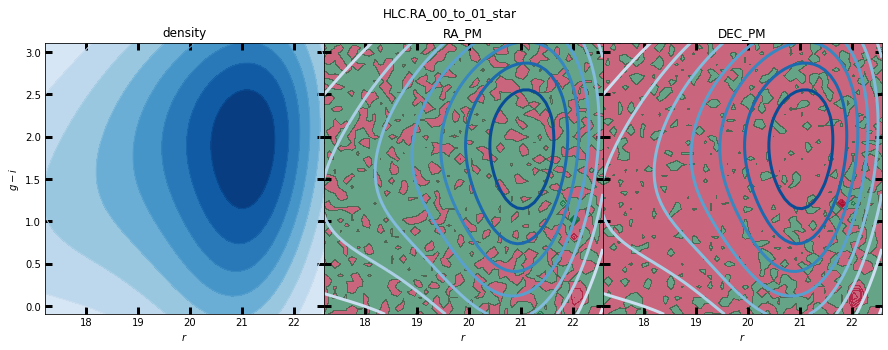

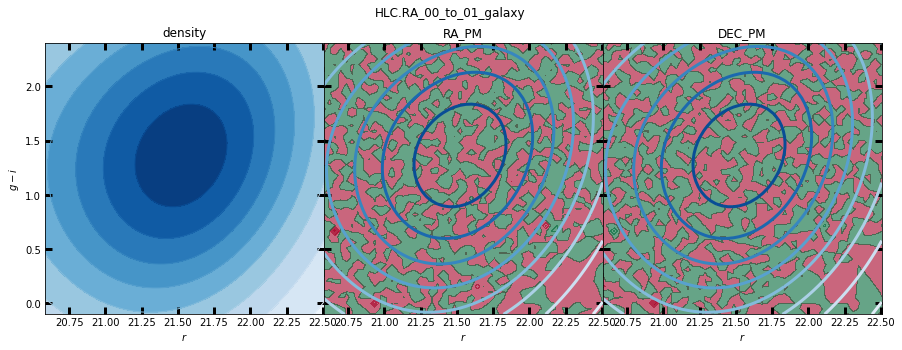

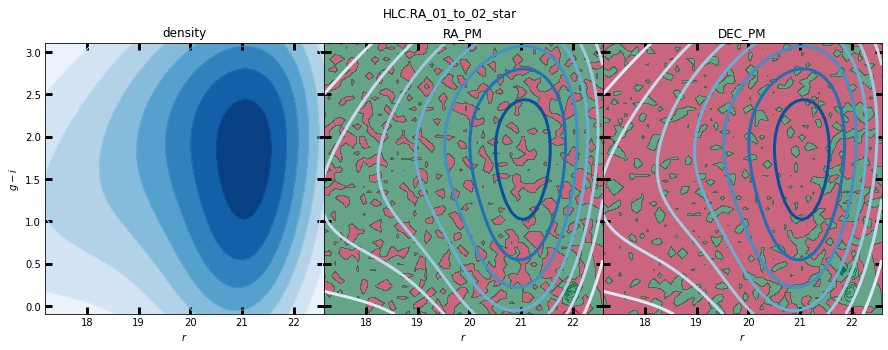

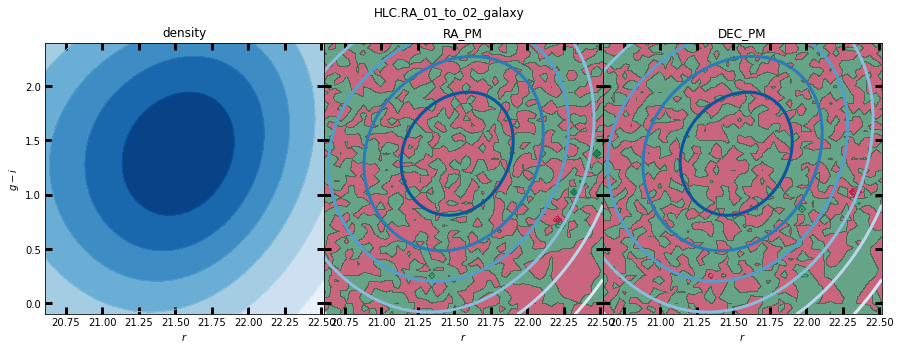

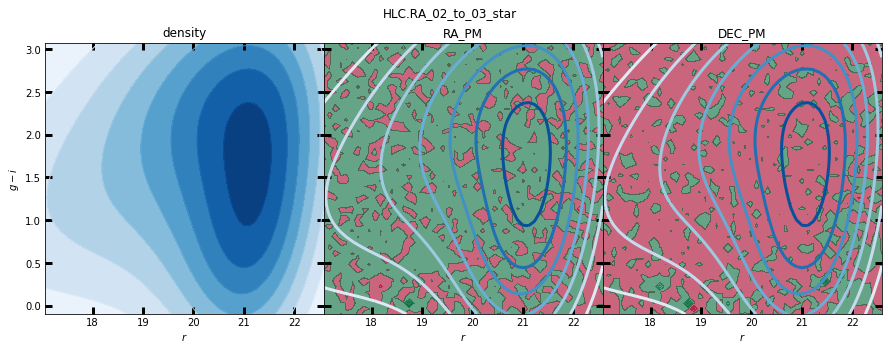

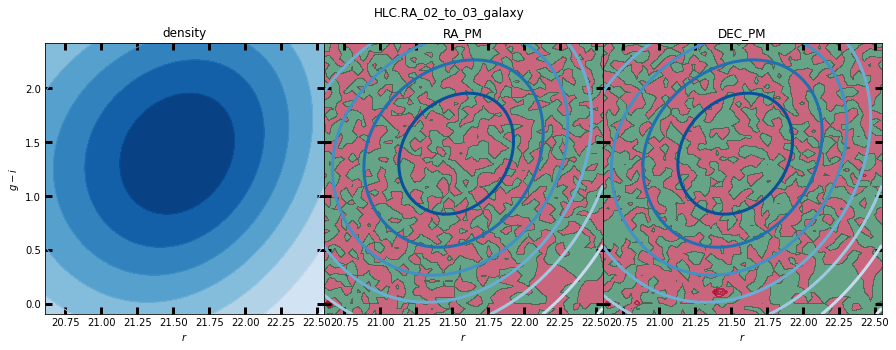

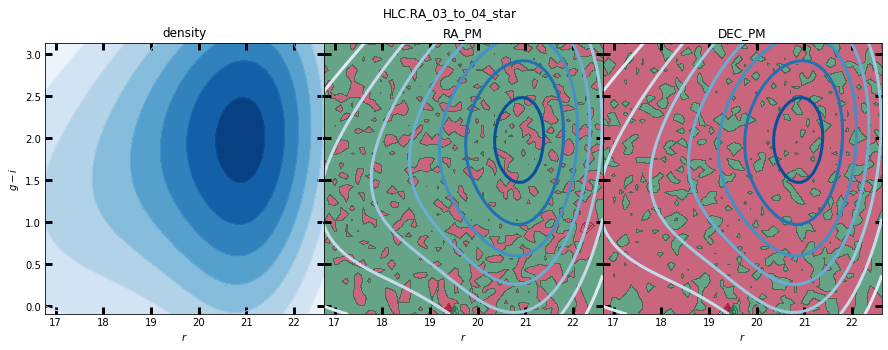

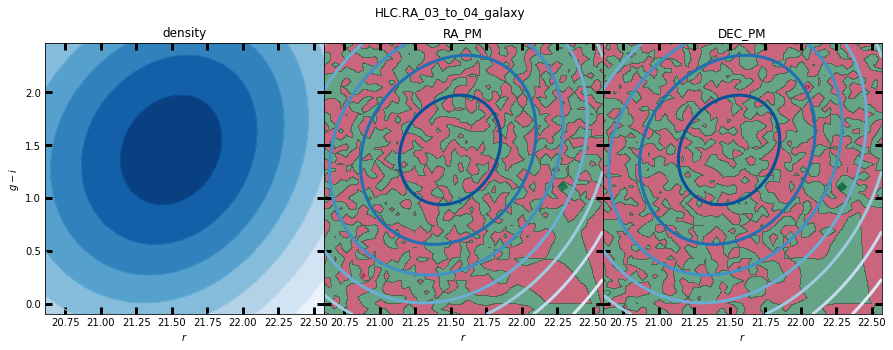

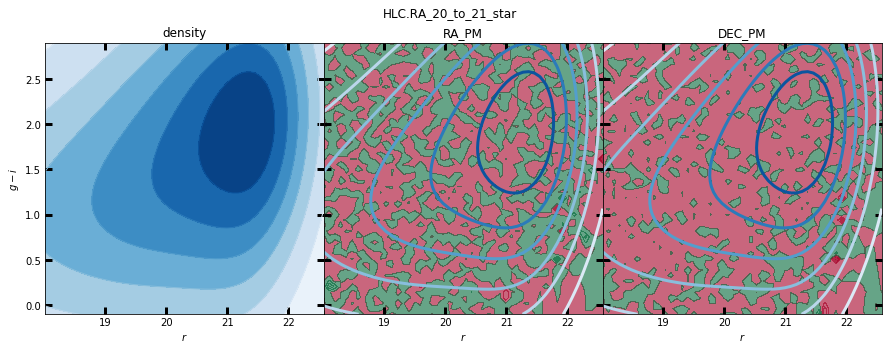

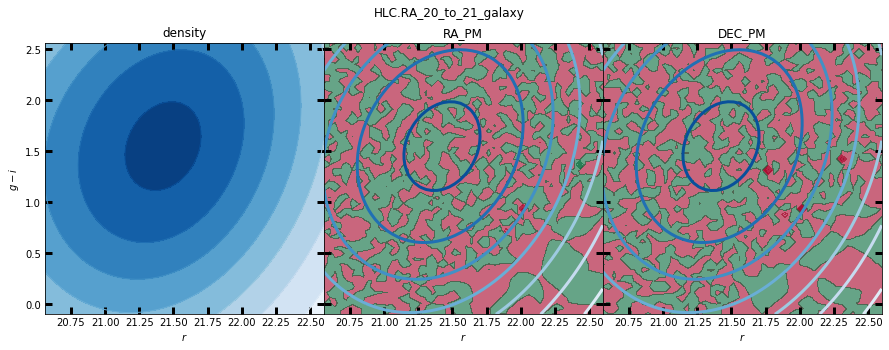

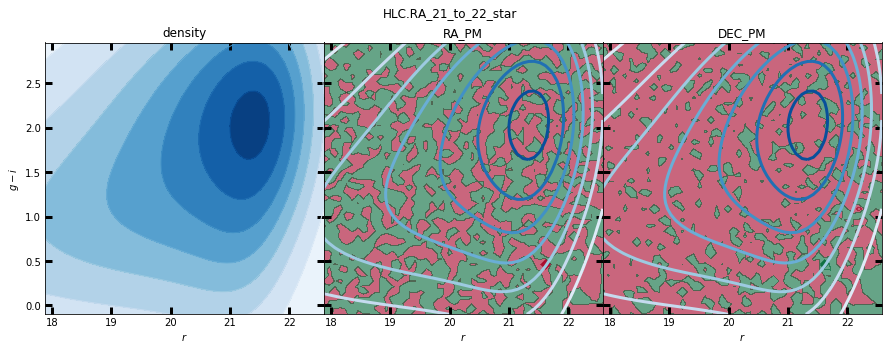

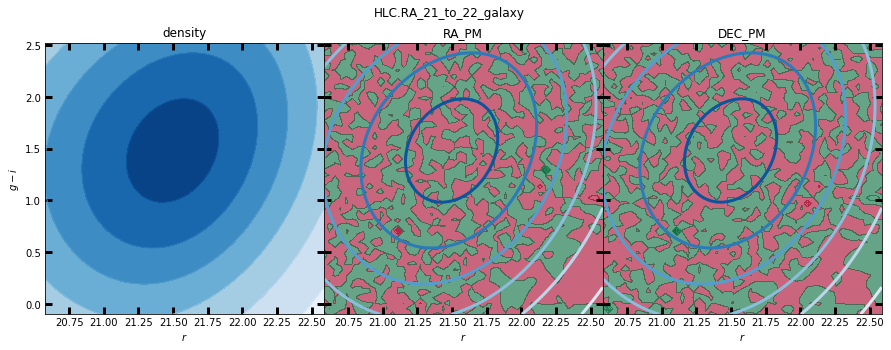

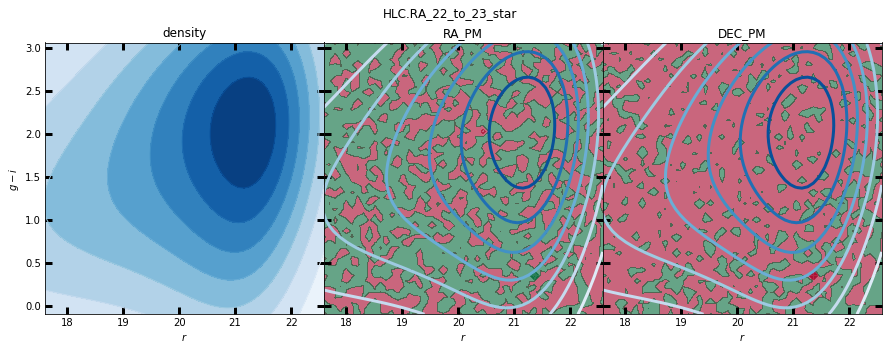

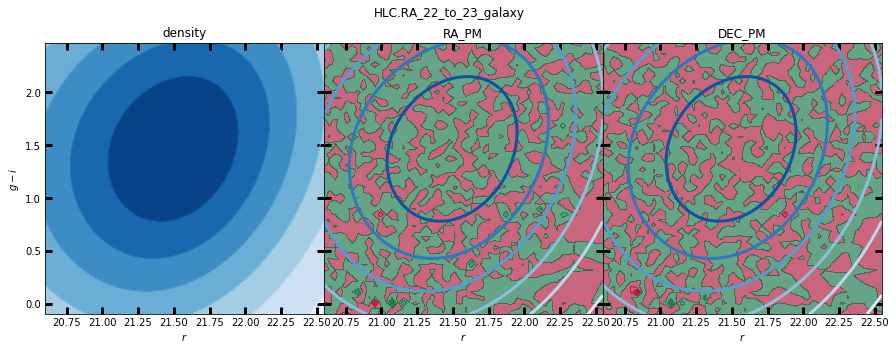

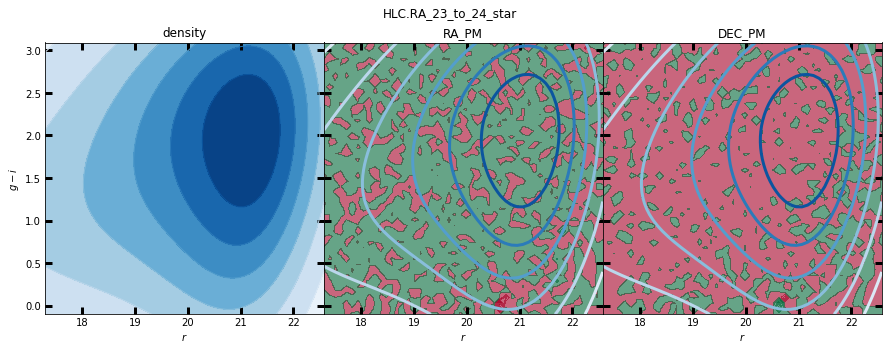

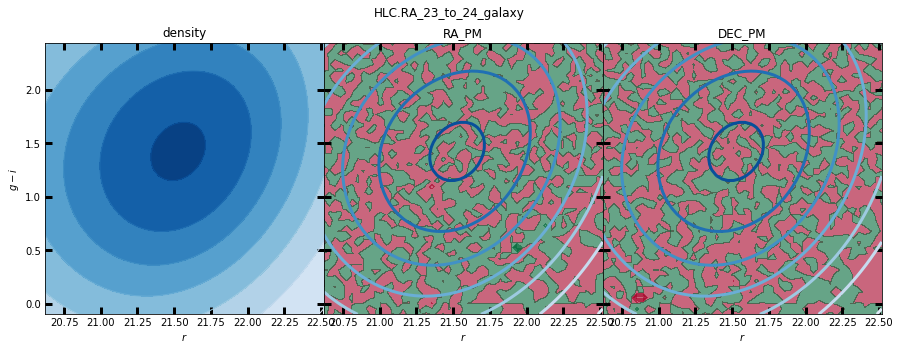

In [5]:
main_plot()

# Problem 2

### Comparing distributions to a standard normal distribution

Load the `IntroStat_demo.csv` file in the data directory (use `pandas` or `astropy` or whatever you like).

Estimate the sample mean and variance of the suspiciously named `mag.outlier` column.

Make a Q-Q plot of the `mag.outlier` column and over plot a line with `Y = Mean + Sigma*X` on it. 

Calculate the values of the first and third quartiles, and use some linear algebra to figure out the equation of a line passing through them (google line 2 point form if you need a refresher on the linear algebra)

Overplot that line passing through the data.

Now try the same thing with `mag.het`. Describe what you found?

What happens if you rescale the data? Subtract of the sample mean of `mag.het` and divide by `mag.het.error`. Now repeat the Q-Q plot with this quantity. 

Describe what's going on.

# Problem 3

The demo data set for this part is the Wesenheit index of the OGLE-III fundamental-mode and first overtone classical Cepheids. 

These stars are awesome because you can use them to measure distances. Here's a nice [youtube video](https://www.youtube.com/watch?v=iyisAjHdhas) on these stars.

You'll try to estimate their period-luminosity relationship. 

The Wesenheit index is defined as `W = I - 1.55(V - I)`, and its main advantage over using simply the I or V photometry is that it is insensitive to extinction. It is denoted by 'W' among the data columns. 

Other columns are 'name', the identifier of the star; 'RA0' (in decimal hours) and 'Decl0' (in decimal degrees), celestial coordinates; 'Mode', the mode of the Cepheid ('F' indicates fundamental-mode, '1' indicates first overtone star); 'Cloud', indicating which Magellanic Cloud the star belongs to; 'logP1', the base-10 logarithm of the period in days; 'VI', the colour V-I.


Split the data into LMC and SMC, and then again by mode F and 1, and plot the `W` on the y-axis vs `log(P1)` on x.
Fit or estimate straight lines to each of the four samples (you can use `statsmodels` `astropy` `scipy` `numpy`....)
(Yes, we've not covered fitting straight lines. That's OK.)

Compute the residuals of each sample to it's respective line. Do these residuals look like a normal distribution? If not, speculate on why (WATCH THE YOUTUBE VIDEO!)

Plot the residuals color coded by if they are positive or negative vs RA and Dec (just like a Hess diagram in Problem 1).

Finally, plot the residuals against the fitted `W` values, and just to anticipate the next homework assignment, also plot `log(P1) vs V-I`. Comment on what you are seeing.